<img style="float: left;padding: 1.3em" src="https://indico.in2p3.fr/event/18313/logo-786578160.png">  

#  Gravitational Wave Open Data Workshop #3


## Tutorial 2.1 PyCBC Tutorial, An introduction to matched-filtering

We will be using the [PyCBC](http://github.com/ligo-cbc/pycbc) library, which is used to study gravitational-wave data, find astrophysical sources due to compact binary mergers, and study their parameters. These are some of the same tools that the LIGO and Virgo collaborations use to find gravitational waves in LIGO/Virgo data 

In this tutorial we will walk through how find a specific signal in LIGO data. We present matched filtering as a cross-correlation, in both the time domain and the frequency domain. In the next tutorial (2.2), we use the method as encoded in PyCBC, which is optimal in the case of Gaussian noise and a known signal model. In reality our noise is not entirely Gaussian, and in practice we use a variety of techniques to separate signals from noise in addition to the use of the matched filter. 

[Click this link to view this tutorial in Google Colaboratory](https://colab.research.google.com/github/gw-odw/odw-2020/blob/master/Day_2/Tuto_2.1_Matched_filtering_introduction.ipynb)

Additional [examples](http://pycbc.org/pycbc/latest/html/#library-examples-and-interactive-tutorials) and module level documentation are [here](http://pycbc.org/pycbc/latest/html/py-modindex.html)

## Installation (un-comment and execute only if running on a cloud platform!)

In [1]:
# -- Use the following for Google Colab
! pip install -q 'lalsuite==6.66' 'PyCBC==1.15.3' 

**Important:** With Google Colab, you may need to restart the runtime after running the cell above.

### Matched-filtering: Finding well modelled signals in Gaussian noise

Matched filtering can be shown to be the optimal method for "detecting" signals---when the signal waveform is known---in Gaussian noise. We'll explore those assumptions a little later, but for now let's demonstrate how this works.

Let's assume you have a stretch of noise, white noise to start:

In [2]:
%matplotlib inline
import numpy
import pylab

# specify the sample rate.
# LIGO raw data is sampled at 16384 Hz (=2^14 samples/second).
# It captures signal frequency content up to f_Nyquist = 8192 Hz.
# Here, we will make the computation faster by sampling at a lower rate.
sample_rate = 1024 # samples per second
data_length = 1024 # seconds

# Generate a long stretch of white noise: the data series and the time series.
data = numpy.random.normal(size=[sample_rate * data_length])
times = numpy.arange(len(data)) / float(sample_rate)

And then let's add a gravitational wave signal to some random part of this data.

16384


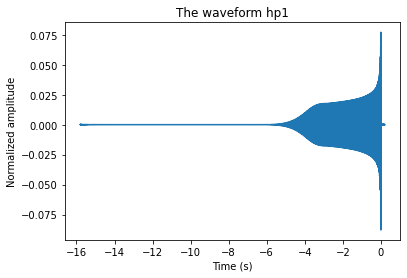

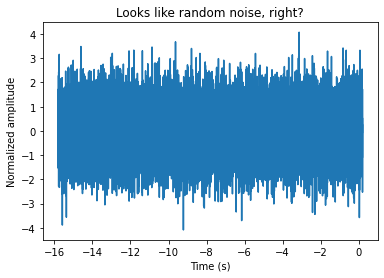

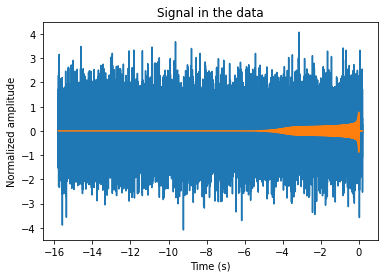

In [3]:
from pycbc.waveform import get_td_waveform

# the "approximant" (jargon for parameterized waveform family).
# IMRPhenomD is defined in the frequency domain, but we'll get it in the time domain (td).
# It runs fast, but it doesn't include effects such as non-aligned component spin, or higher order modes.
apx = 'IMRPhenomD'

# You can specify many parameters, 
# https://pycbc.org/pycbc/latest/html/pycbc.waveform.html?highlight=get_td_waveform#pycbc.waveform.waveform.get_td_waveform
# but here, we'll use defaults for everything except the masses.
# It returns both hplus and hcross, but we'll only use hplus for now.
hp1, _ = get_td_waveform(approximant=apx,
                         mass1=10,
                         mass2=10,
                         delta_t=1.0/sample_rate,
                         f_lower=25)

# The amplitude of gravitational-wave signals is normally of order 1E-20. To demonstrate our method
# on white noise with amplitude O(1) we normalize our signal so the cross-correlation of the signal with
# itself will give a value of 1. In this case we can interpret the cross-correlation of the signal with white
# noise as a signal-to-noise ratio.

hp1 = hp1 / max(numpy.correlate(hp1,hp1, mode='full'))**0.5

# note that in this figure, the waveform amplitude is of order 1.
# The duration (for frequency above f_lower=25 Hz) is only 3 or 4 seconds long.
# The waveform is "tapered": slowly ramped up from zero to full strength, over the first second or so.
# It is zero-padded at earlier times.
pylab.figure()
pylab.title("The waveform hp1")
pylab.plot(hp1.sample_times, hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

# Shift the waveform to start at a random time in the Gaussian noise data.
waveform_start = numpy.random.randint(0, len(data) - len(hp1))
data[waveform_start:waveform_start+len(hp1)] += 10 * hp1.numpy()

pylab.figure()
pylab.title("Looks like random noise, right?")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

pylab.figure()
pylab.title("Signal in the data")
pylab.plot(hp1.sample_times, data[waveform_start:waveform_start+len(hp1)])
pylab.plot(hp1.sample_times, 10 * hp1)
pylab.xlabel('Time (s)')
pylab.ylabel('Normalized amplitude')

print(len(hp1))

To search for this signal we can cross-correlate the signal with the entire dataset -> Not in any way optimized at this point, just showing the method.

We will do the cross-correlation in the time domain, once for each time step. It runs slowly...

Text(0, 0.5, 'Cross-correlation')

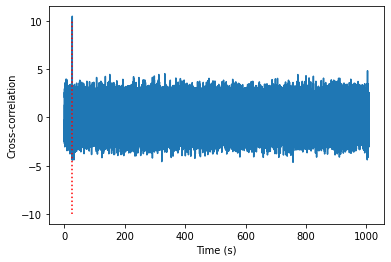

In [4]:
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1_numpy = hp1.numpy()
for i in range(len(data) - len(hp1_numpy)):
    cross_correlation[i] = (hp1_numpy * data[i:i+len(hp1_numpy)]).sum()

# plot the cross-correlated data vs time. Superimpose the location of the end of the signal;
# this is where we should find a peak in the cross-correlation.
pylab.figure()
times = numpy.arange(len(data) - len(hp1_numpy)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)], [-10,10],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

new series [ 0.25964383  0.0390433  -0.87006094 ...  0.53219082 -0.16174415
  0.86527419]
[1.66262047e+02 1.66286911e+02 1.66361533e+02 ... 8.72887052e-04
 8.72853087e-04 8.72841765e-04]
psd 524289
psd via GWOSC 513
power_vec 1048576
size template BEFORE 16384
size template AFTER 1048576
new SNR [1.54723366 0.84704958 0.56664815 ... 0.71928297 1.68367151 1.69645894]
We found a signal at 26.00390625s with SNR 12.8838143420432


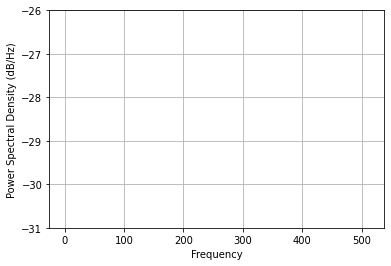

In [16]:
from pycbc.psd import interpolate, inverse_spectrum_truncation
from pycbc.types import TimeSeries
# Estimate the power spectral density
import matplotlib.pyplot as plt
import numpy as np

fs=1024
new_series=TimeSeries(data,1.0/sample_rate)
print('new series',new_series)


# We use 4 second samples of our time series in Welch method.
psd =new_series.psd(4)

# Now that we have the psd we need to interpolate it to match our data
# and then limit the filter length of 1 / PSD. After this, we can
# directly use this PSD to filter the data in a controlled manner
psd = interpolate(psd,new_series.delta_f)

# 1/PSD will now act as a filter with an effective length of 4 seconds
# Since the data has been highpassed above 15 Hz, and will have low values
# below this we need to inform the function to not include frequencies
# below this frequency. 
psd = inverse_spectrum_truncation(psd, 4 *new_series.sample_rate,
                                  low_frequency_cutoff=15)



print(psd)
print('psd',len(psd))

# -- Calculate the PSD of the data
power_data, freq_psd = plt.psd(data[40*fs:], Fs=fs, NFFT=fs, visible=False)
print('psd via GWOSC',len(power_data))



# -- Interpolate to get the PSD values at the needed frequencies
datafreq = np.fft.fftfreq(data.size)*fs
power_vec = np.interp(datafreq, freq_psd, power_data)

print('power_vec',len(power_vec))

data_fft=np.fft.fft(data)
template=hp1
print('size template BEFORE',len(template))

zero_pad = np.zeros(len(data) - len(template))
template_padded = np.append(template, zero_pad)
print('size template AFTER',len(template_padded))
template_fft = np.fft.fft(template_padded)

# -- Calculate the matched filter output
optimal = data_fft * template_fft.conjugate() / power_vec
optimal_time = 2*np.fft.ifft(optimal)

# -- Normalize the matched filter output
df = np.abs(datafreq[1] - datafreq[0])
sigmasq = 2*(template_fft * template_fft.conjugate() / power_vec).sum() * df
sigma = np.sqrt(np.abs(sigmasq))
SNR = abs(optimal_time) / (sigma)

new_snr=TimeSeries(SNR,1.0/sample_rate)
print('new SNR',new_snr)

peak = abs(new_snr).numpy().argmax()
snrp = new_snr[peak]
time = new_snr.sample_times[peak]

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))

1048576
[0. 0. 0. ... 0. 0. 0.]
0.0
1032192
something 0.0
nan
nan
[ 0.25964383  0.0390433  -0.87006094 ...  0.53219082 -0.16174415
  0.86527419]
[ 0.00010391 -0.00010144  0.00010286 ...  0.          0.
  0.        ]
1048576 1048576
1048576


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in true_divide
  if sys.path[0] == '':


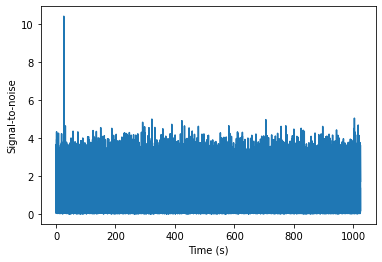

###
[ 1.20313266+0.55885539j  0.52963847+1.22034481j -0.32115487+1.05087658j
 ...  0.34161204-1.38563706j  1.30817049-0.89461841j
  1.34080323-0.03797884j]
######
[0.00000000e+00 9.76562500e-04 1.95312500e-03 ... 1.02399707e+03
 1.02399805e+03 1.02399902e+03]
We found a signal at 26.00390625s with SNR 10.405886027223948
1048576 1048576
1048576


In [21]:
print(len(hp1))
from pycbc.filter import matched_filter
import numpy as np
import matplotlib.pyplot as plt
print(cross_correlation)
p=cross_correlation.argmax()
print(cross_correlation[p])
print(len(cross_correlation))
print('something',np.amax(cross_correlation))


snrnew=abs(p)/np.std(cross_correlation)
print(snrnew)
print(abs(snrnew))

print(data)
print(hp1)
print(len(data),len(hp1))

zero_pad = np.zeros(len(data) - len(hp1))
o=len(data)-len(hp1)
hp1.append_zeros(o)

print(len(new_series))

snr = matched_filter(hp1, new_series,
                     psd=psd, low_frequency_cutoff=20)


pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()


print('###')
print(snr)
print('######')
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print(snr.sample_times)

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))



print(len(data),len(new_series))

print(len(hp1))

Here you can see that the largest spike from the cross-correlation comes at the time of the signal. We only really need one more ingredient to describe matched-filtering: "Colored" noise (Gaussian noise but with a frequency-dependent variance; white noise has frequency-independent variance). 

Let's repeat the process, but generate a stretch of data colored with LIGO's zero-detuned--high-power noise curve. We'll use a PyCBC library to do this.

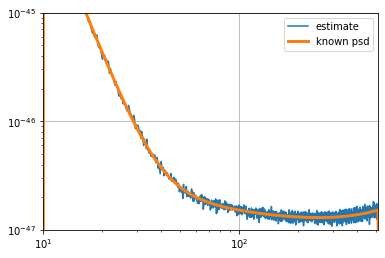

ValueError: ignored

In [23]:
# http://pycbc.org/pycbc/latest/html/noise.html
import pycbc.noise
import pycbc.psd

# The color of the noise matches a PSD which you provide:
# Generate a PSD matching Advanced LIGO's zero-detuned--high-power noise curve 
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, flow)

# Generate colored noise
delta_t = 1.0 / sample_rate
ts = pycbc.noise.noise_from_psd(data_length*sample_rate, delta_t, psd, seed=127)

# Estimate the amplitude spectral density (ASD = sqrt(PSD)) for the noisy data 
# using the "welch" method. We'll choose 4 seconds PSD samples that are overlapped 50%
seg_len = int(4 / delta_t)
seg_stride = int(seg_len / 2)
estimated_psd = pycbc.psd.welch(ts,seg_len=seg_len,seg_stride=seg_stride)

# plot it:
pylab.loglog(estimated_psd.sample_frequencies, estimated_psd, label='estimate')
pylab.loglog(psd.sample_frequencies, psd, linewidth=3, label='known psd')
pylab.xlim(xmin=flow, xmax=512)
pylab.ylim(1e-47, 1e-45)
pylab.legend()
pylab.grid()
pylab.show()

# add the signal, this time, with a "typical" amplitude.
ts[waveform_start:waveform_start+len(hp1)] += hp1.numpy() * 1E-20

Then all we need to do is to "whiten" both the data, and the template waveform. This can be done, in the frequency domain, by dividing by the PSD. This *can* be done in the time domain as well, but it's more intuitive in the frequency domain

In [15]:
# Generate a PSD for whitening the data
from pycbc.types import TimeSeries

# The PSD, sampled properly for the noisy data
flow = 10.0
delta_f = 1.0 / data_length
flen = int(sample_rate / (2 * delta_f)) + 1
psd_td = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

print('psd_td',psd_td)
print(len(psd_td))

# The PSD, sampled properly for the signal
delta_f = sample_rate / float(len(hp1))
flen = int(sample_rate / (2 * delta_f)) + 1
psd_hp1 = pycbc.psd.aLIGOZeroDetHighPower(flen, delta_f, 0)

# The 0th and Nth values are zero. Set them to a nearby value to avoid dividing by zero.
psd_td[0] = psd_td[1]
psd_td[len(psd_td) - 1] = psd_td[len(psd_td) - 2]
# Same, for the PSD sampled for the signal
psd_hp1[0] = psd_hp1[1]
psd_hp1[len(psd_hp1) - 1] = psd_hp1[len(psd_hp1) - 2]

# convert both noisy data and the signal to frequency domain,
# and divide each by ASD=PSD**0.5, then convert back to time domain.
# This "whitens" the data and the signal template. 
# Multiplying the signal template by 1E-21 puts it into realistic units of strain.
data_whitened = (ts.to_frequencyseries() / psd_td**0.5).to_timeseries()
hp1_whitened = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() 

psd_td [0.00000000e+00 6.14940975e-25 1.92183116e-26 ... 1.52486657e-47
 1.52486806e-47 0.00000000e+00]
524289


In [24]:
import numpy as np
from pycbc.filter import matched_filter

hp1_cross = (hp1.to_frequencyseries() / psd_hp1**0.5).to_timeseries() * 1E-21
print(data_whitened)
print(hp1_whitened)
print(len(data_whitened),len(hp1_whitened))

zero_pad = np.zeros(len(data_whitened) - len(hp1_whitened))
o=len(data_whitened)-len(hp1_whitened)
print('difference',o)
hp1_whitened.append_zeros(o)
print(len(data_whitened),len(hp1_whitened))


snr = matched_filter(hp1_whitened, data_whitened,
                     psd=psd, low_frequency_cutoff=20)


pylab.plot(snr.sample_times, abs(snr))
pylab.ylabel('Signal-to-noise')
pylab.xlabel('Time (s)')
pylab.show()


print('###')
print(snr)
print('######')
peak = abs(snr).numpy().argmax()
snrp = snr[peak]
time = snr.sample_times[peak]
print(snr.sample_times)

print("We found a signal at {}s with SNR {}".format(time, 
                                                    abs(snrp)))


ValueError: ignored

ValueError: ignored

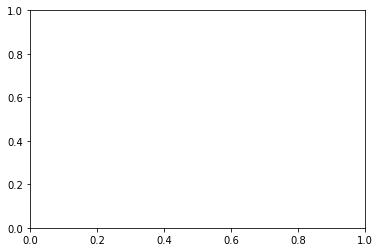

In [14]:
# Now let's re-do the correlation, in the time domain, but with whitened data and template.
cross_correlation = numpy.zeros([len(data)-len(hp1)])
hp1n = hp1_whitened.numpy()
datan = data_whitened.numpy()
for i in range(len(datan) - len(hp1n)):
    cross_correlation[i] = (hp1n * datan[i:i+len(hp1n)]).sum()

# plot the cross-correlation in the time domain. Superimpose the location of the end of the signal.
# Note how much bigger the cross-correlation peak is, relative to the noise level,
# compared with the unwhitened version of the same quantity. SNR is much higher!
pylab.figure()
times = numpy.arange(len(datan) - len(hp1n)) / float(sample_rate)
pylab.plot(times, cross_correlation)
pylab.plot([waveform_start/float(sample_rate), waveform_start/float(sample_rate)],
           [(min(cross_correlation))*1.1,(max(cross_correlation))*1.1],'r:')
pylab.xlabel('Time (s)')
pylab.ylabel('Cross-correlation')

In [41]:
from pycbc.filter import matched_filter
import numpy as np
print(cross_correlation)
p1=cross_correlation.argmax()
print(cross_correlation[p1])
print(len(cross_correlation))
print('something',np.amax(cross_correlation))


snrnew1=abs(p1)/np.std(cross_correlation,dtype=float)
print(snrnew1)
print(abs(snrnew1))

[ 1480.0970572  -1565.66867226 -3086.77176444 ...  2057.01678522
 -4865.69267692 -9313.51231189]
307926.1117021279
1032192
something 307926.1117021279
14.728310363883335
14.728310363883335


# Challenge!

* Histogram the whitened time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation? (We have not been careful in normalizing the whitened data properly).
* Histogram the above cross-correlation time series. Ignoring the outliers associated with the signal, is it a Gaussian? What is the mean and standard deviation?
* Find the location of the peak. (Note that here, it can be positive or negative), and the value of the SNR of the signal (which is the absolute value of the peak value, divided by the standard deviation of the cross-correlation time series).

## Optional challenge question. much harder:
* Repeat this process, but instead of using a waveform with mass1=mass2=10, try 15, 20, or 25. Plot the SNR vs mass. Careful! Using lower masses (eg, mass1=mass2=1.4 Msun) will not work here. Why?

### Optimizing a matched-filter

That's all that a matched-filter is. A cross-correlation of the data with a template waveform performed as a function of time. This cross-correlation walking through the data is a convolution operation. Convolution operations are more optimally performed in the frequency domain, which becomes a `O(N ln N)` operation, as opposed to the `O(N^2)` operation shown here. You can also conveniently vary the phase of the signal in the frequency domain, as we will illustrate in the next tutorial. PyCBC implements a frequency-domain matched-filtering engine, which is much faster than the code we've shown here. Let's move to the next tutorial now, where we will demonstrate its use on real data.